# Goal: 

Find the defining motifs of a work within the same corpus.
    
# Methodology:

We use a linear classification technique which takes the following form:
$$y_i = \alpha_1 X_{i1} + \alpha_2 X_{i2} + \ldots + \alpha_p X_{ip} = f_\alpha(X)$$
where $y$ indicates the document $i$ and $X_i$ is a vector of features computed from motifs of length $p$ for the document $i$.

Instead of fitting this classifier at the work piece level, we split each work into windows of fixed length which then represent the documents $i \in \{1, \ldots, n\}$. 

We apply the pipeline in order to obtain the motif annotations (or any other token). Then, we compute the $X_i$ which are defined as the TFIDF scores of each motif within each document in the corpus, where a document represents a window of motifs, as stated above.

To fit the model, we simply minimize the Mean Squarred Error as in a classical multinomial logistic regression framework. However, in order to select the most important motifs, we apply the L1 regularization which forces non-informative features to have a 0 coefficient.

# Import librairies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler

from motifs.pipeline import Pipeline
from motifs.features import build_tfidf, transform_corpus_to_ngrams
from motifs.utils import build_window_corpus, return_to_text_from_token

In [2]:
# Define the path of the corpus
# corpus_dir="/Users/brunospilak/Documents/Sorbonne/PyMotifs/data/corpus_motifs_10"
# tokens_dir = None
tokens_dir="/Users/brunospilak/Documents/Sorbonne/PyMotifs/data/corpus_motifs_10/tokens"
corpus_dir = None
# Define the token type: AVAILABLE_TOKEN_TYPES = ["text", "lemma", "pos", "motif"]
token_type = "motif"
# Define the feature on which to perform PCA analysis
feature = {"name": "tfidf", "params": {"normalize": False, "smartirs": "nfc"}}
# n-gram length
n = 5

pipeline = Pipeline(token_type, corpus_dir=corpus_dir, tokens_dir=tokens_dir, save=False)
pipeline.transform_to_ngrams(n)
ngrams = pipeline.ngrams
ngrams.head()

[PyMotifs-Logger:pipeline.py:92] - [28301] - 2024-02-21 13:29:13 - DEBUG - Loading tokens from directory: /Users/brunospilak/Documents/Sorbonne/PyMotifs/data/corpus_motifs_10/tokens...
[PyMotifs-Logger:pipeline.py:95] - [28301] - 2024-02-21 13:29:14 - DEBUG - Done in 1.13 secs.
[PyMotifs-Logger:features.py:49] - [28310] - 2024-02-21 13:29:16 - DEBUG - Steps to go 10
[PyMotifs-Logger:features.py:49] - [28311] - 2024-02-21 13:29:16 - DEBUG - Steps to go 9
[PyMotifs-Logger:features.py:49] - [28312] - 2024-02-21 13:29:16 - DEBUG - Steps to go 8
[PyMotifs-Logger:features.py:49] - [28313] - 2024-02-21 13:29:16 - DEBUG - Steps to go 7
[PyMotifs-Logger:features.py:49] - [28316] - 2024-02-21 13:29:16 - DEBUG - Steps to go 6
[PyMotifs-Logger:features.py:49] - [28317] - 2024-02-21 13:29:16 - DEBUG - Steps to go 5
[PyMotifs-Logger:features.py:49] - [28319] - 2024-02-21 13:29:16 - DEBUG - Steps to go 4
[PyMotifs-Logger:features.py:49] - [28322] - 2024-02-21 13:29:16 - DEBUG - Steps to go 2
[PyMotif

,word,text,token,doc
0,Prologue,Prologue Ce livre est avant,NC ce NC être avant,1998_Houellebecq-Michel_Les-particules-element...
1,Ce,Ce livre est avant tout,ce NC être avant tout,1998_Houellebecq-Michel_Les-particules-element...
2,livre,livre est avant tout l',NC être avant tout le,1998_Houellebecq-Michel_Les-particules-element...
3,est,est avant tout l' histoire,être avant tout le NC,1998_Houellebecq-Michel_Les-particules-element...
4,avant,avant tout l' histoire d',avant tout le NC de,1998_Houellebecq-Michel_Les-particules-element...


# Build window of fixed length from the data

In [3]:
seq_length = 5000
data = build_window_corpus(ngrams, seq_length)
# Create class mapper
class_mapper = {d: i for i, d in enumerate(data["doc"].unique())}
data["class"] = [class_mapper[data["doc"][i]] for i in range(len(data))]
data["doc"] = data["doc"] + "_w_" + data["window"].astype(str)
doc = data.doc.unique().tolist()
data.head()

,window,text,token,doc,class
0,0,Prologue Ce livre est avant,NC ce NC être avant,1998_Houellebecq-Michel_Les-particules-element...,0
1,0,Ce livre est avant tout,ce NC être avant tout,1998_Houellebecq-Michel_Les-particules-element...,0
2,0,livre est avant tout l',NC être avant tout le,1998_Houellebecq-Michel_Les-particules-element...,0
3,0,est avant tout l' histoire,être avant tout le NC,1998_Houellebecq-Michel_Les-particules-element...,0
4,0,avant tout l' histoire d',avant tout le NC de,1998_Houellebecq-Michel_Les-particules-element...,0


# Class distribution

<Axes: xlabel='class', ylabel='proportion'>

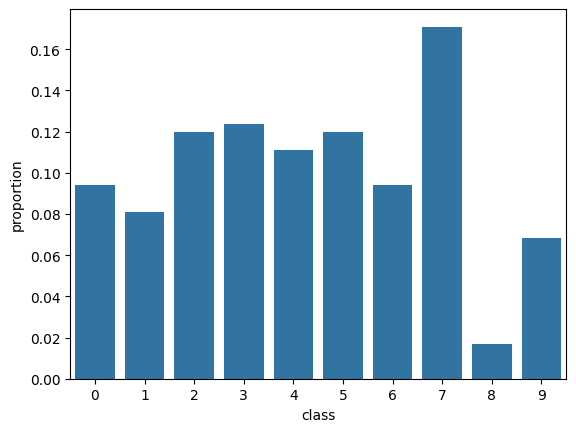

In [4]:
windows = data[["doc", "class"]].drop_duplicates(keep="first")
sns.countplot(windows, x="class", stat="proportion")

# Train/test split

In [5]:
test_size = 0.3
random_state = 0 # For reproducibility
np.random.seed(random_state)
# Use StratifiedShuffleSplit to keep class balance
sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
train_idx, test_idx = list(sss.split(windows["doc"], windows["class"]))[0]

train_data = data[data["doc"].isin(windows.iloc[train_idx]["doc"])]
test_data = data[data["doc"].isin(windows.iloc[test_idx]["doc"])]

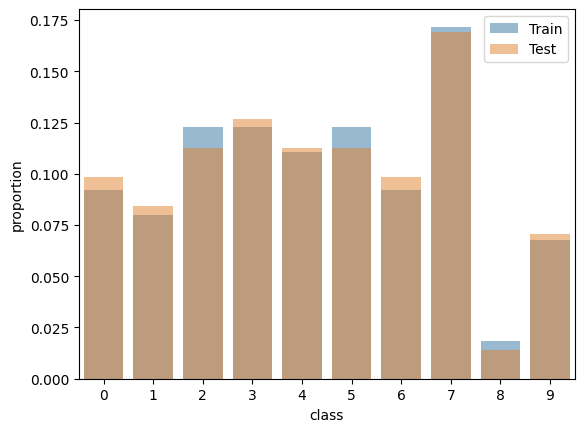

In [6]:
sns.countplot(windows.iloc[train_idx], x="class", label="Train", stat="proportion", alpha=0.5)
sns.countplot(windows.iloc[test_idx], x="class", label="Test", stat="proportion", alpha=0.5)
plt.legend()
plt.show()

# Featurization (TFIDF)

In [48]:
## Train set

t1 = time.time()
train_tfidf, model, dictionary = build_tfidf(train_data, normalize=False, smartirs="nfn")
t2 = time.time()
print(f"{t2-t1:.2f}")

# Test set
t1 = time.time()
test_tfidf, _, _ = build_tfidf(test_data, model=model, dictionary=dictionary, normalize=False, smartirs="nfn") # Use train_idf
t2 = time.time()
print(f"{t2-t1:.2f}")

31.62
12.77


In [49]:
# Transform to a table with documents as indices and tokens as columns
t1 = time.time()
train_tfidf = train_tfidf.pivot_table(values="tfidf", columns="token", index="doc")
t2 = time.time()
print(f"{t2-t1:.2f}")
t1 = time.time()
test_tfidf = test_tfidf.pivot_table(values="tfidf", columns="token", index="doc")
t2 = time.time()
print(f"{t2-t1:.2f}")

(train_tfidf.shape, test_tfidf.shape)

50.92
24.94


((163, 428980), (71, 568892))

In [50]:
# Remove new tokens and add missing ones in the test set
if set(train_tfidf.columns) != set(test_tfidf.columns):
    missing_features_in_test = pd.DataFrame(0, columns=list(set(train_tfidf.columns) - set(test_tfidf.columns)), index=test_tfidf.index)
    test_tfidf = pd.concat([test_tfidf, missing_features_in_test], axis=1)
    test_tfidf = test_tfidf[train_tfidf.columns]
    
    missing_features_in_train = list(set(test_tfidf.columns) - set(train_tfidf.columns))
    if len(missing_features_in_train):
        # Remove new features in test set (they are equal to 0 anyway)
        test_tfidf.drop(missing_features_in_train, axis=1, inplace=True)
(train_tfidf.shape, test_tfidf.shape)

((163, 428980), (71, 428980))

In [51]:
# Shuffle the train set
indices = list(range(len(train_tfidf)))
np.random.shuffle(indices)
train_tfidf = train_tfidf.iloc[indices]

## we obtain more than 400K features, that is too many! We must introduce a criterion for feature selection.

Since we know that a token which as a tfidf of 0 corresponds to non-informative tokens, we propose a simple solution solution based on the sparsity of each column of the `train_features` matrix. We define the sparsity level as the proportion of 0 in a column of a matrix ($\forall j, \operatorname{S}_j = 1/n\sum_i \operatorname{I}\{M_{ij} = 0\}$ where $n$ is the number of rows in matrix $M$ and $j$ represents a token as column). The more sparse the column of a token, the less informative is the token within the corpus, since it is more common to all documents. Then, we simply apply a treshold, for ex $u = 0.8$, and we select $j$ if $\operatorname{S}_j \leq u$.

In [52]:
sparsity = np.sum(train_tfidf == 0, axis=0)/len(train_tfidf)
to_keep = sparsity.index[sparsity < 0.9]
train_tfidf = train_tfidf[to_keep]
test_tfidf = test_tfidf[to_keep]

# Normalization

In [53]:
scaler = MinMaxScaler(feature_range=(0,1))
train_features = scaler.fit_transform(train_tfidf)
test_features = scaler.transform(test_tfidf)

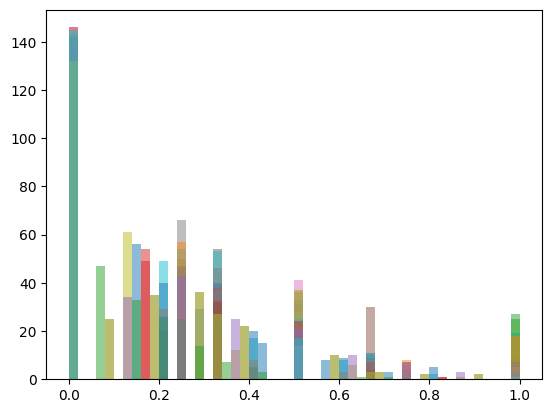

In [54]:
for _ in range(100):
    plt.hist(train_features[:, np.random.randint(train_features.shape[-1])],
             bins=50, alpha=0.5)
plt.show()

In [55]:
train_y = np.array([class_mapper[i.split("w")[0][:-1]] for i in train_tfidf.index])
test_y = np.array([class_mapper[i.split("w")[0][:-1]] for i in test_tfidf.index])

# Model

In [56]:
train_features.shape

(163, 3239)

/Users/brunospilak/miniconda3/envs/pymotifs/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Train accuracy 100.0
Test accuracy 70.4225352112676
Sparisty 97.53627662858906


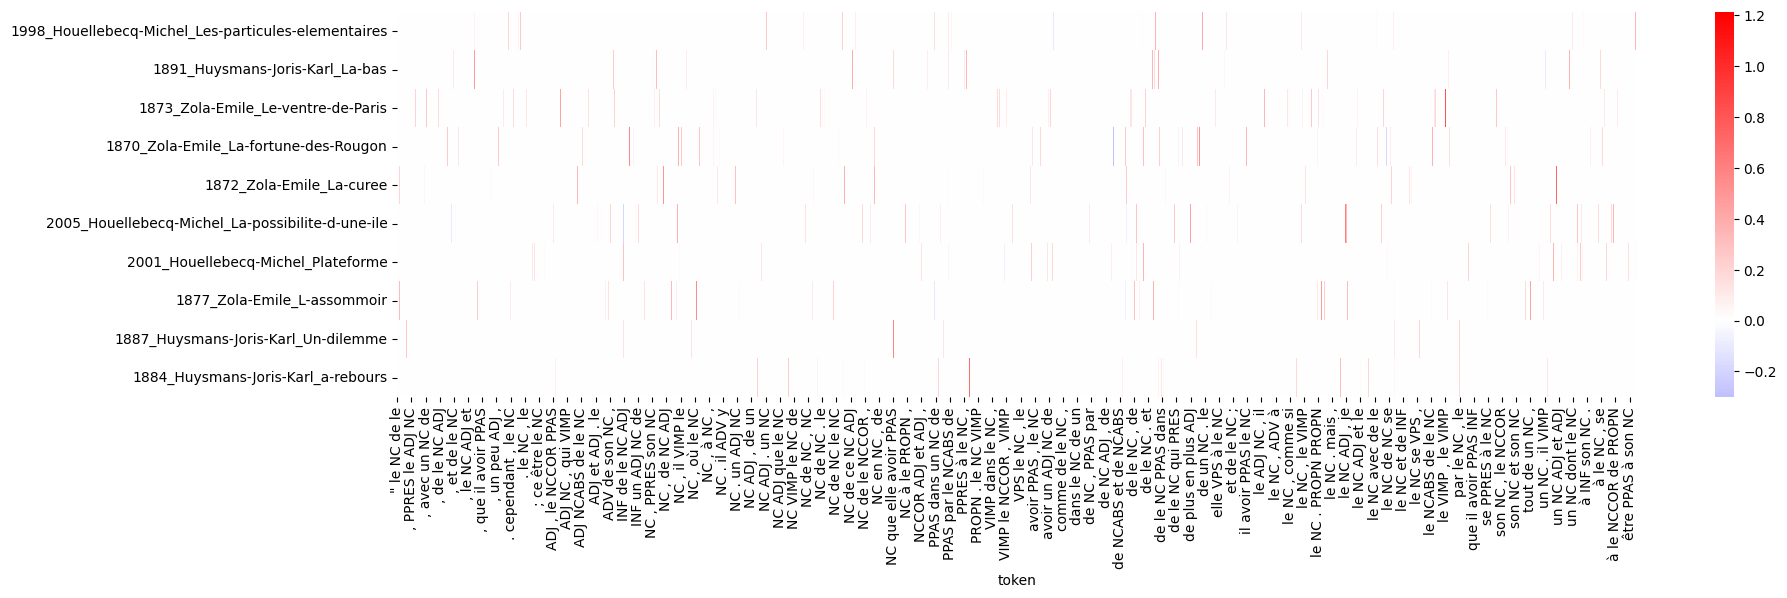

In [57]:
# Since we have a still a lot of features (2256) compared to the number of observations (163), we propose to use a L1 regularization to select the most important features
# It introduces one hyperparameter: C (the strength of the penalty).
# It will force many parameters to be 0, which introduce sparsity in the solution, thus it is easier to interpret

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    multi_class='multinomial', solver='saga', penalty='l1', C=0.99, random_state=random_state,
)
clf.fit(train_features, train_y)

print("Train accuracy", clf.score(train_features, train_y) * 100)
print("Test accuracy", clf.score(test_features, test_y) * 100)
print("Sparisty", np.mean(clf.coef_ == 0) * 100)

coefs = pd.DataFrame(clf.coef_, columns=train_tfidf.columns, index=class_mapper.keys())

plt.figure(figsize=(20,5))
sns.heatmap(coefs, cmap="bwr", center=0)
plt.show()

In [58]:
sum(coefs.loc['1998_Houellebecq-Michel_Les-particules-elementaires',:] != 0)

79

We observe that only 79 tokens are enough to predict if a document belongs to "Les particules elementaires"

# Features importance

The plot below represents the regression coefficients for each document which can be interpreted as the features' importance.

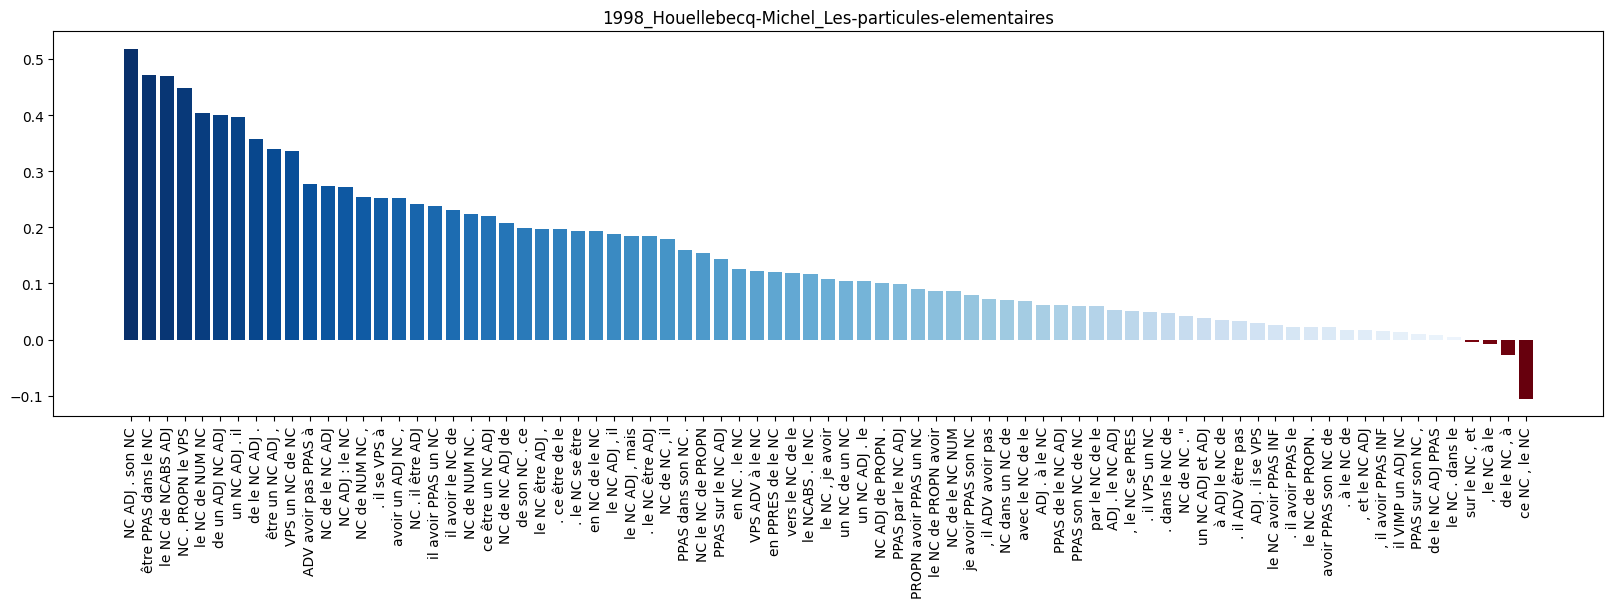

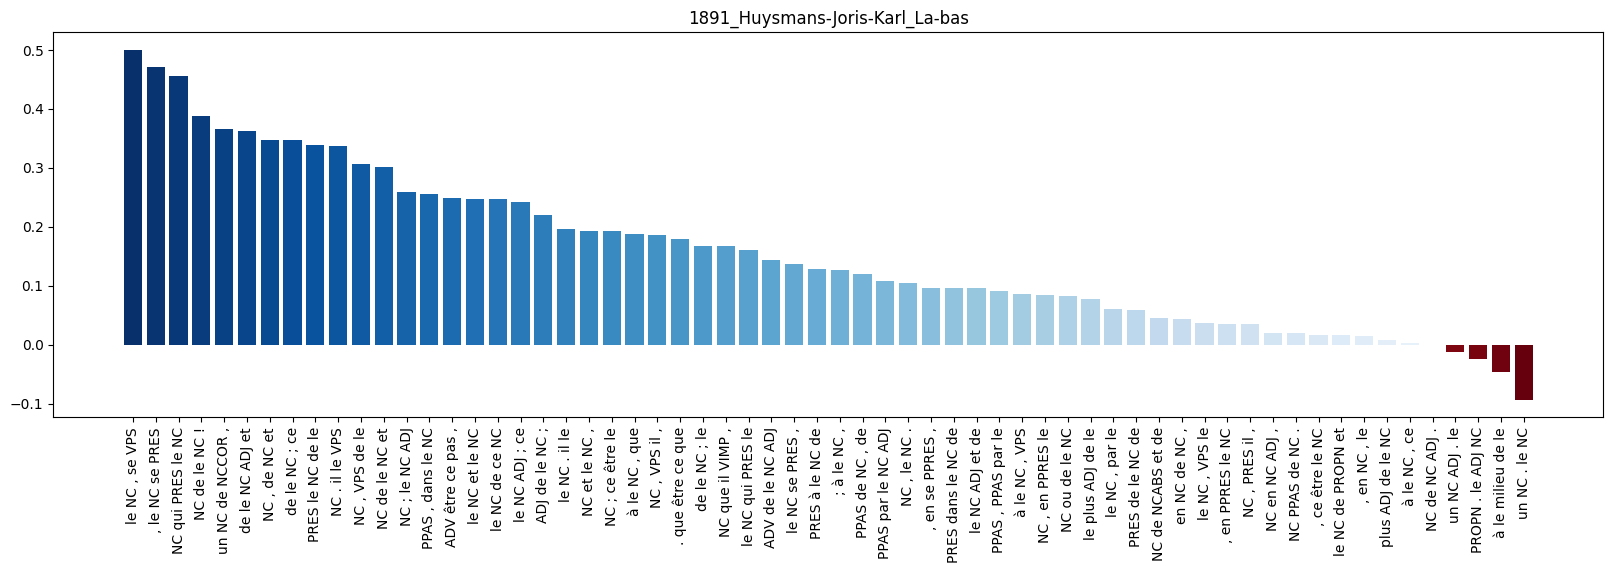

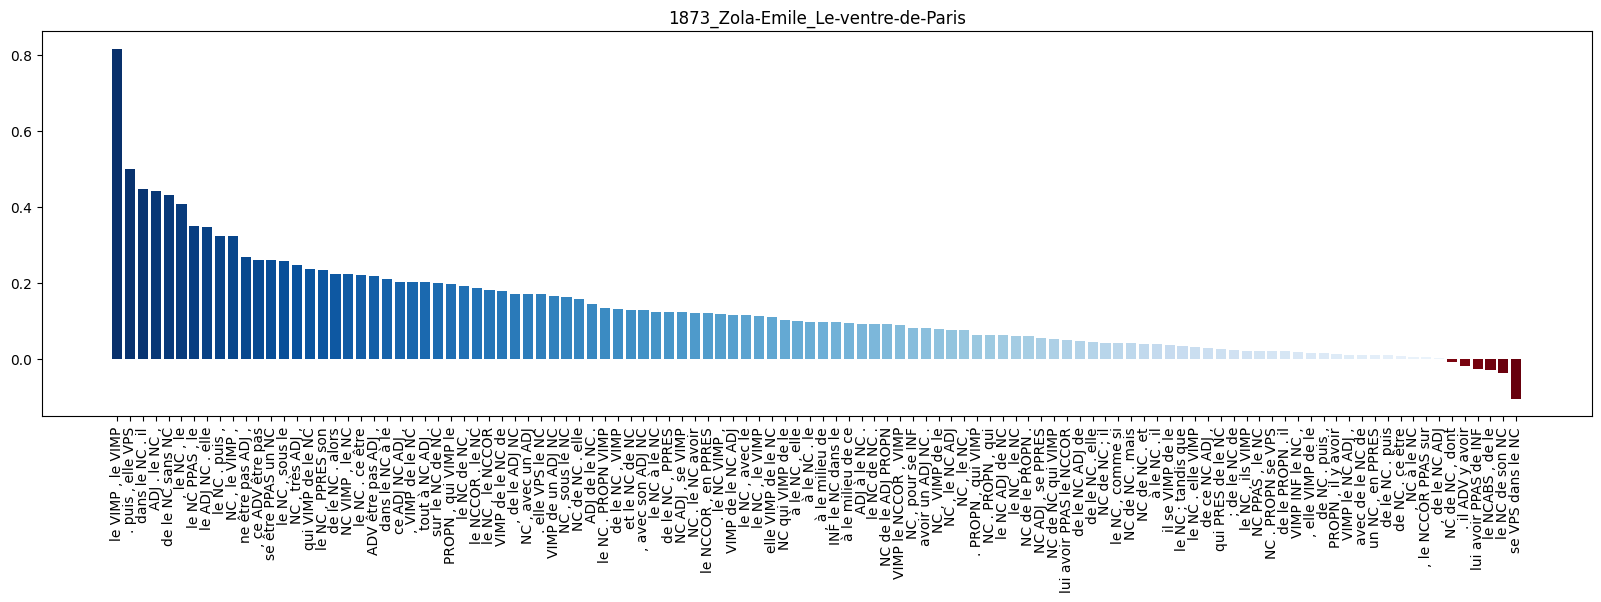

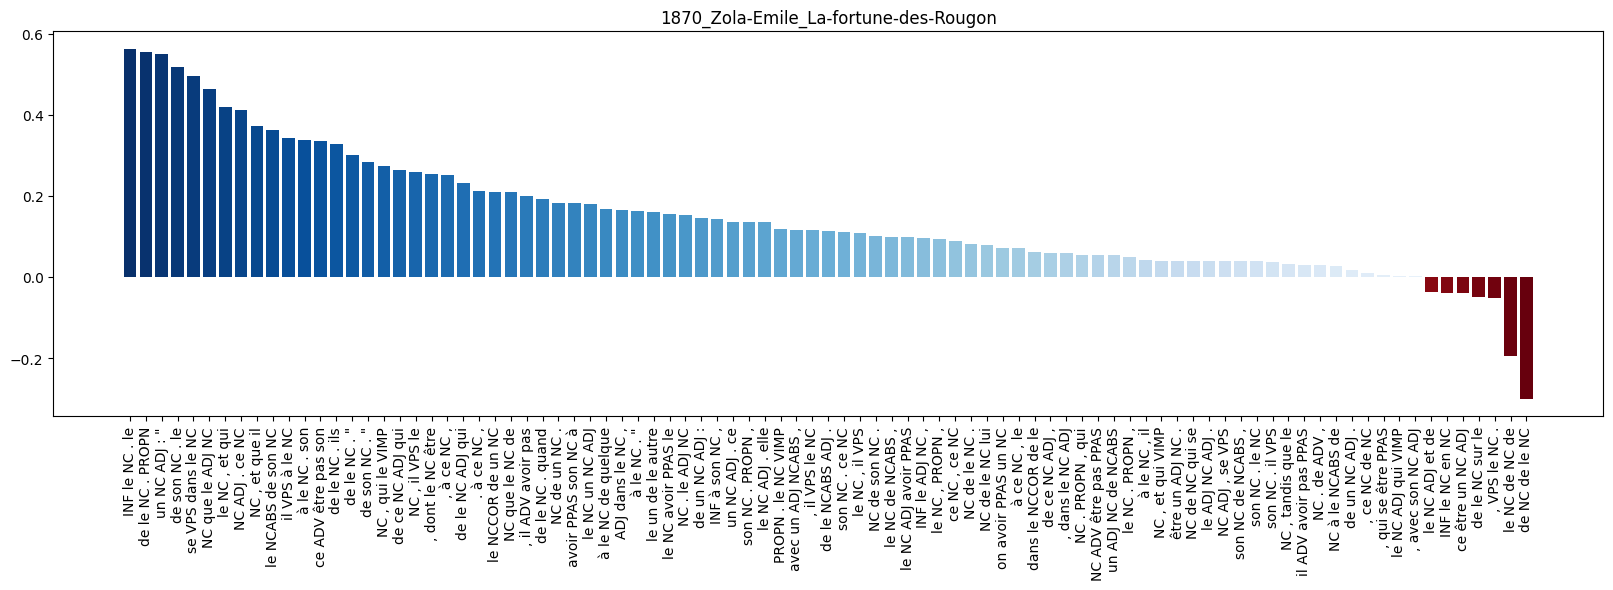

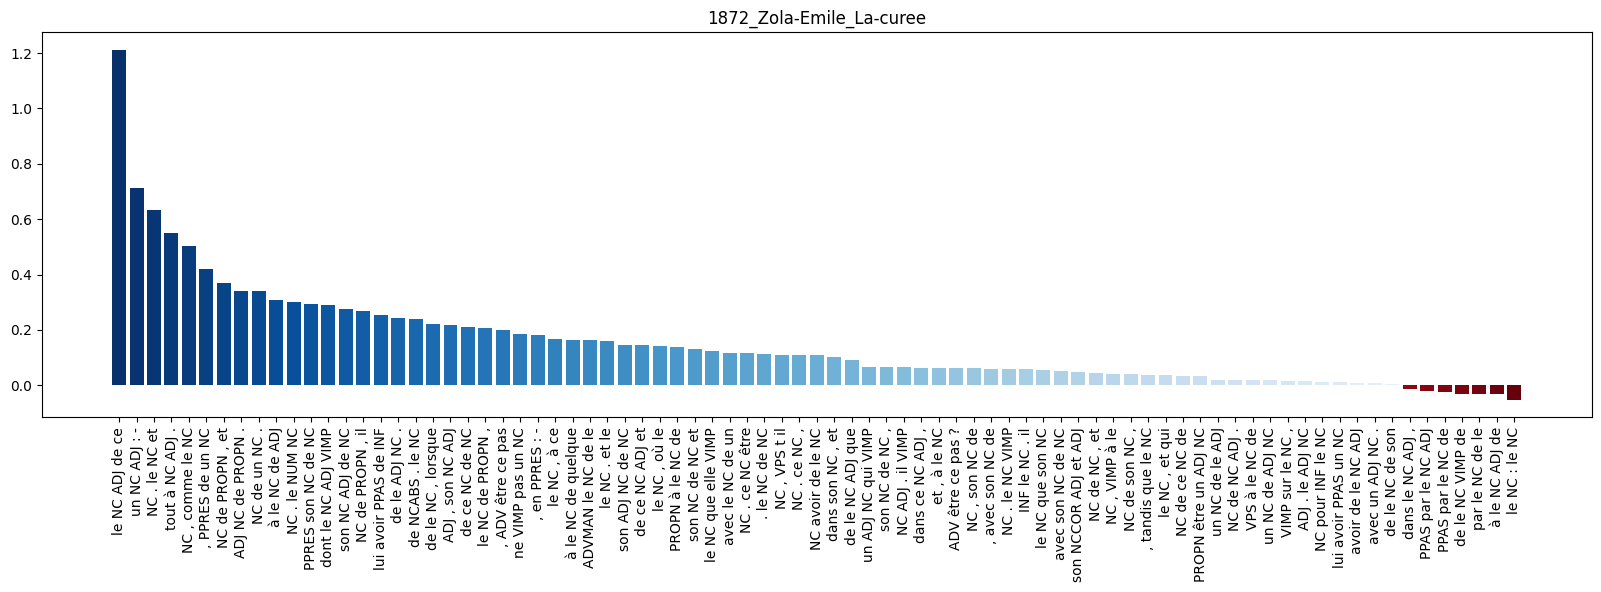

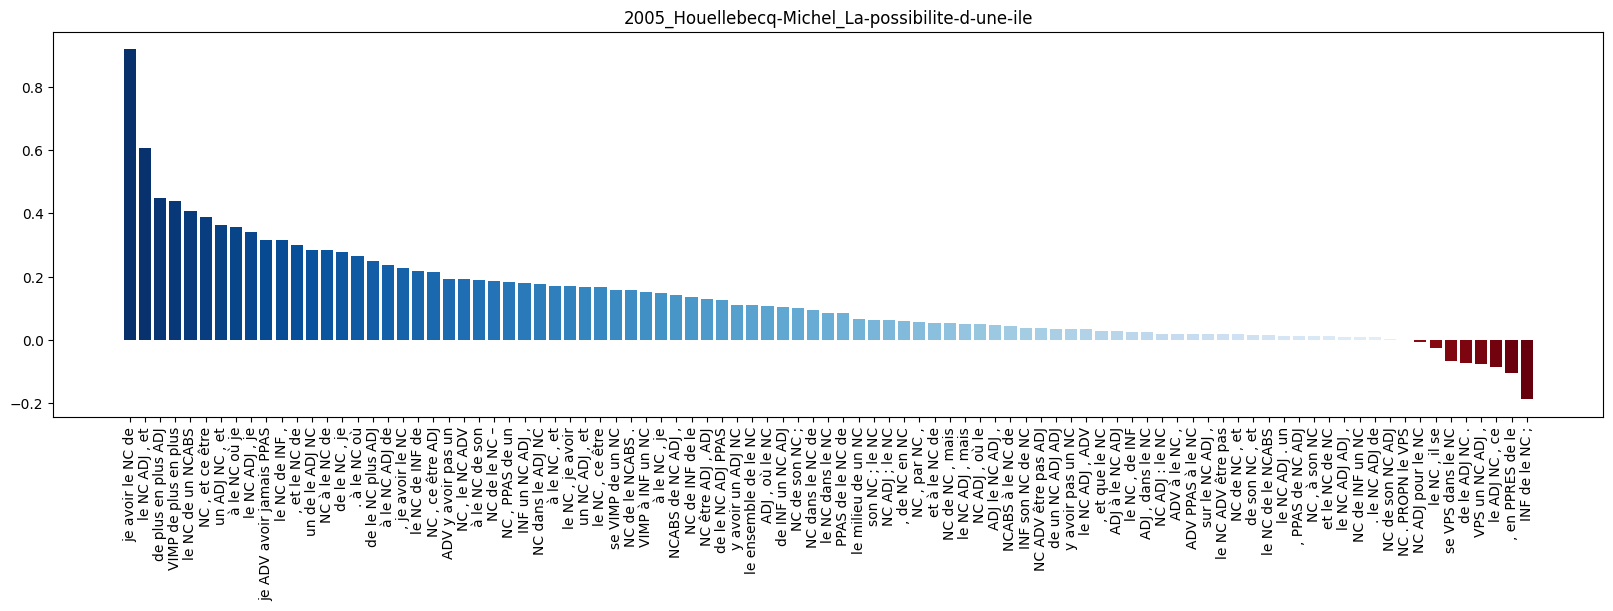

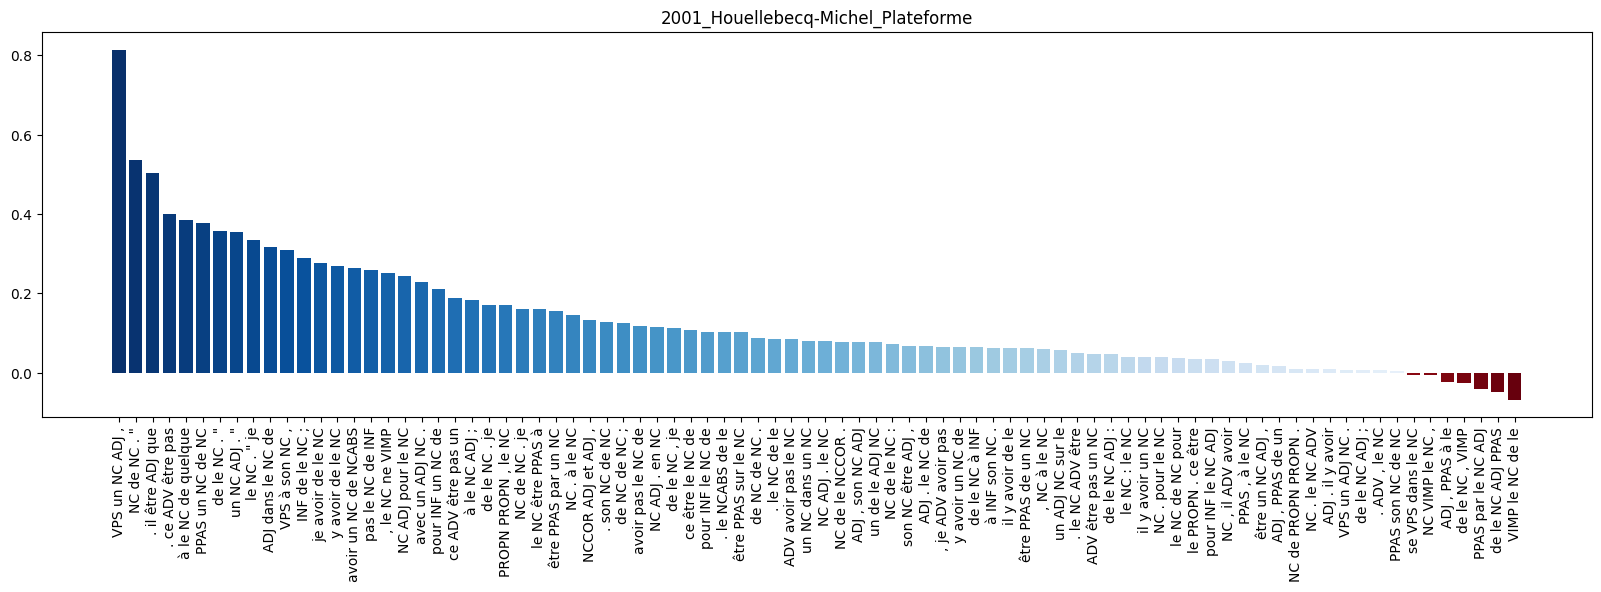

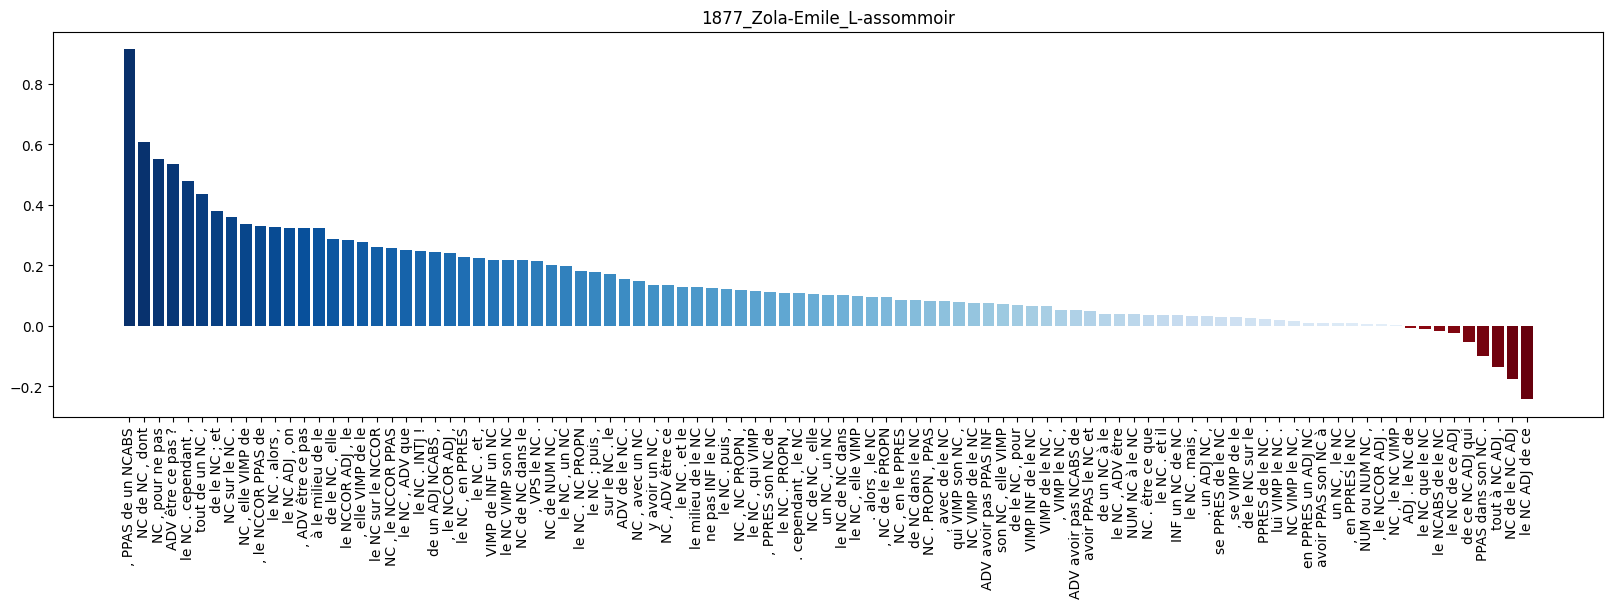

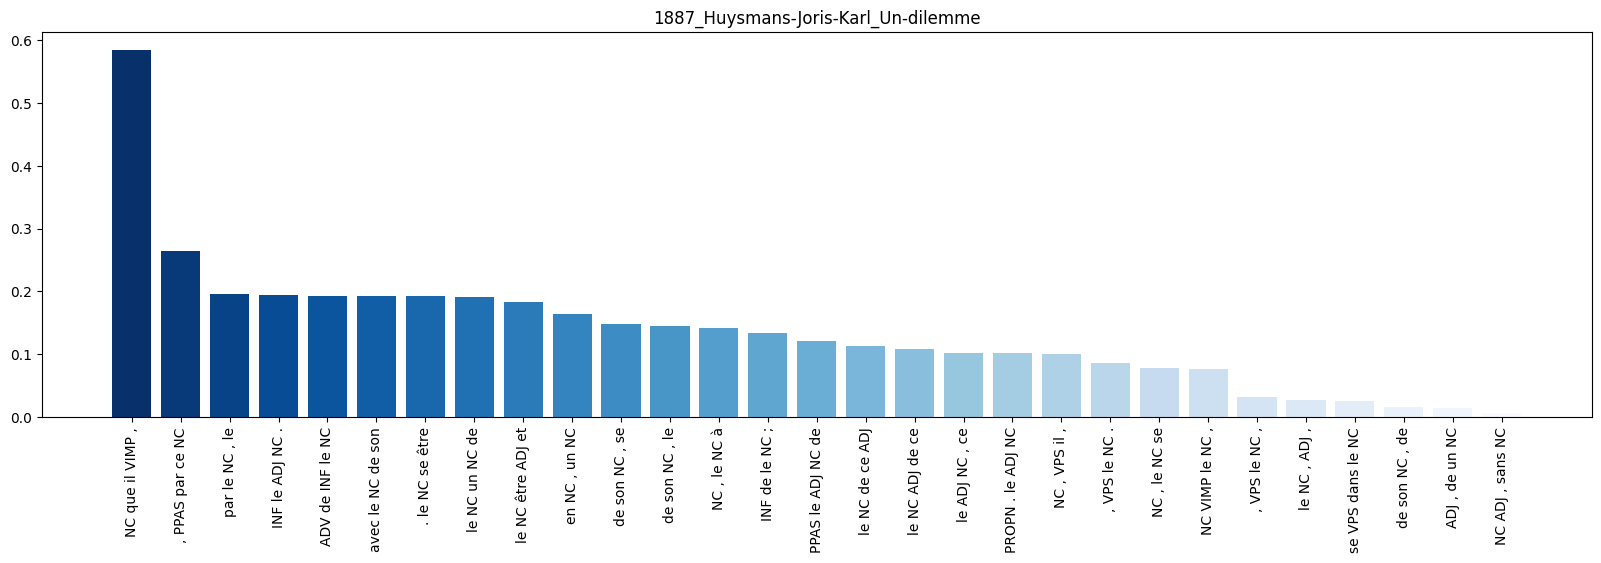

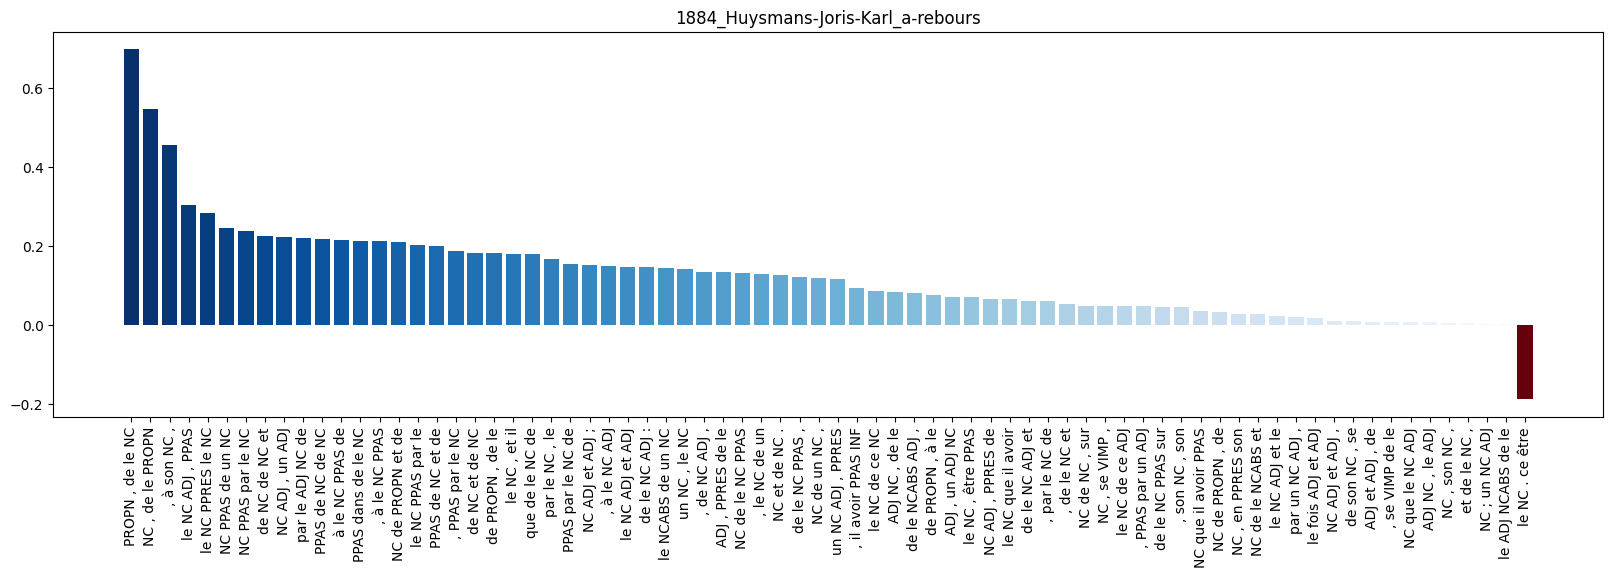

In [59]:
selected_features = {i: coefs.columns[coefs.loc[i] != 0].tolist() for i in coefs.index}
selected_features = {i: coefs.loc[i, f].sort_values(ascending=False) for i, f in selected_features.items()}


my_cmap = plt.get_cmap("bwr")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))



for i in selected_features:
    
    values = selected_features[i]
    # Separate positive and negative values
    positive_values = [val if val > 0 else 0 for val in selected_features[i]]
    negative_values = [val if val < 0 else 0 for val in selected_features[i]]

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(20,5))

    # Plot positive values with varying shades of blue
    ax.bar(range(len(positive_values)), positive_values, color=plt.cm.Blues(np.linspace(0, 1, len(positive_values)))[::-1])

    # Plot negative values with varying shades of red
    ax.bar(range(len(negative_values)), negative_values, color=plt.cm.Reds(np.linspace(0, 1, len(negative_values))))

    # Customize the plot
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(selected_features[i].index, rotation=90)
    ax.set_title(i)
    plt.show()

In [61]:
most_important_motifs = coefs.idxmax(1)
doc = "1998_Houellebecq-Michel_Les-particules-elementaires"
print(most_important_motifs[doc], coefs.loc[doc, most_important_motifs[doc]])

NC ADJ . son NC 0.5180204


The most important motif for "Les particules elementaires" by Houellebecq is "son NC ; il" with a coefficient of 0.49. It means that the presence of this motif in a document (window of length n) will increase the probability that a document belongs to "Les particules elementaires" by 49%.

# Return to text

In [62]:
context_len = 8
doc = "1998_Houellebecq-Michel_Les-particules-elementaires"
context = return_to_text_from_token(ngrams[ngrams["doc"] == doc], most_important_motifs[doc], n, context_len)
context

,left_context,text,right_context,doc,token
0,"; puis il les photographiait , sous une",lumière rasante . Son reportage,sur Saint-Tropez connut un grand succès dans le,1998_Houellebecq-Michel_Les-particules-element...,NC ADJ . son NC
1,", son clan avait été décimé par une",éruption volcanique . Son père,", Craô le Sage , n' avait pu",1998_Houellebecq-Michel_Les-particules-element...,NC ADJ . son NC
2,Le lendemain de l' enterrement eut lieu une,scène étrange . Son père,"et sa mère , qu' il voyait tous",1998_Houellebecq-Michel_Les-particules-element...,NC ADJ . son NC
3,", que son adolescence en général était un",échec lamentable . Son père,"s' en rendait compte , et se sentait",1998_Houellebecq-Michel_Les-particules-element...,NC ADJ . son NC
4,"en acier , qui avait été inauguré l'",année précédente . Sa tante,Marie-Thérèse et sa cousine Brigitte l' attend...,1998_Houellebecq-Michel_Les-particules-element...,NC ADJ . son NC
5,"de sept ans , à le milieu de",semi-brutes alcooliques . Son adolescence,avait été trop brève pour qu' elle en,1998_Houellebecq-Michel_Les-particules-element...,NC ADJ . son NC
6,"qu' en haut , elle avait passé un",sweat-shirt gris . Son mont,de Vénus avait une jolie courbure ; malheureus...,1998_Houellebecq-Michel_Les-particules-element...,NC ADJ . son NC
7,""" Huxley appartenait à une grande famille de",biologistes anglais . Son grand-père,"était un ami de Darwin , il a",1998_Houellebecq-Michel_Les-particules-element...,NC ADJ . son NC
8,", il a beaucoup écrit pour défendre les",thèses évolutionnistes . Son père,et son frère Julian étaient également de les,1998_Houellebecq-Michel_Les-particules-element...,NC ADJ . son NC
9,l' élément passif de le déploiement d' un,mouvement historique . Ses motivations,", ses valeurs , ses désirs : rien",1998_Houellebecq-Michel_Les-particules-element...,NC ADJ . son NC


Houellebecq, in "Les particules élémentaires", seems to like oppostions using NC ADJ which precedes the opposition.

In [63]:
doc = "1891_Huysmans-Joris-Karl_La-bas"
context = return_to_text_from_token(ngrams[ngrams["doc"] == doc], most_important_motifs[doc], n, context_len)
context

,left_context,text,right_context,doc,token
0,commença de vivre dans le pacifiant mépris de,"les alentours , s' organisa",une existence loin de le brouhaha de les,1891_Huysmans-Joris-Karl_La-bas,"le NC , se VPS"
1,organisa une existence loin de le brouhaha de,"les lettres , se cloîtra","mentalement , pour tout dire , dans le",1891_Huysmans-Joris-Karl_La-bas,"le NC , se VPS"
2,"tourna sur la console , le long de","le mur , se dirigea",vers la lumière qui pénétrait par les auvents,1891_Huysmans-Joris-Karl_La-bas,"le NC , se VPS"
3,"à le plus vite , ses bras dans","le lit , s' acagnarda",sous ses couvertures . C' est un bon,1891_Huysmans-Joris-Karl_La-bas,"le NC , se VPS"
4,"se glissa , emplit la robe , bomba","le corsage , s' insinua",sous le hennin à deux cornes d' où,1891_Huysmans-Joris-Karl_La-bas,"le NC , se VPS"
5,", jusqu' à l' entrée ; elle ouvrit","la porte , se retourna",", lui prit la main et très doucement",1891_Huysmans-Joris-Karl_La-bas,"le NC , se VPS"
6,"son tour , s' en fut jusqu' à","la porte , s' assura",", d' un coup d' oeil , qu'",1891_Huysmans-Joris-Karl_La-bas,"le NC , se VPS"
7,bête . Il jeta de nouvelles bûches dans,"la cheminée , se vêtit",", laissa à Hyacinthe la chambre libre .",1891_Huysmans-Joris-Karl_La-bas,"le NC , se VPS"
8,c' est l' incarnation de le maudit sur,"la terre , s' écria","Carhaix , en aidant ses amis à endosser",1891_Huysmans-Joris-Karl_La-bas,"le NC , se VPS"
9,d' ennui . Il se déshabilla près de,"le feu , se chauffa",", attendant qu' elle fut couchée . Une",1891_Huysmans-Joris-Karl_La-bas,"le NC , se VPS"


This is only because the the character "Des Hermies" has a last name with a particle.

In [64]:
doc = "1873_Zola-Emile_Le-ventre-de-Paris"
context = return_to_text_from_token(ngrams[ngrams["doc"] == doc], most_important_motifs[doc], n, context_len)
context

,left_context,text,right_context,doc,token
0,", marquaient la viande d' un timbre ,","la voituraient , la pesaient",", l' accrochaient à les barres de la",1873_Zola-Emile_Le-ventre-de-Paris,"le VIMP , le VIMP"
1,"viande d' un timbre , la voituraient ,","la pesaient , l' accrochaient",à les barres de la criée ; tandis,1873_Zola-Emile_Le-ventre-de-Paris,"le VIMP , le VIMP"
2,de l' origine de sa fortune ; cela,"le gênait , l' empêchait",de dire tout net son opinion sur la,1873_Zola-Emile_Le-ventre-de-Paris,"le VIMP , le VIMP"
3,oncle Gradelle et sur les Quenu ; elle,"les détaillait , les prenait","par tous les bouts , les savait """,1873_Zola-Emile_Le-ventre-de-Paris,"le VIMP , le VIMP"
4,"quinzaine de jours , l' arrivée de Florent","la désorientait , la brûlait",d' une véritable fièvre de curiosité . Elle,1873_Zola-Emile_Le-ventre-de-Paris,"le VIMP , le VIMP"
5,comme on disait la belle Lisa . Cela,"les opposait , les comparait",", les forçait à soutenir chacune sa renommée",1873_Zola-Emile_Le-ventre-de-Paris,"le VIMP , le VIMP"
6,"la belle Lisa . Cela les opposait ,","les comparait , les forçait",à soutenir chacune sa renommée de beauté .,1873_Zola-Emile_Le-ventre-de-Paris,"le VIMP , le VIMP"
7,", il les prenait avec un bâton ,","les enroulait , les portait","dans la cour , où ils devaient sécher",1873_Zola-Emile_Le-ventre-de-Paris,"le VIMP , le VIMP"
8,"une poignée la paille de les bourriches ,","les vidaient , les jetaient",", vivement ; et , sur les larges",1873_Zola-Emile_Le-ventre-de-Paris,"le VIMP , le VIMP"
9,coquetterie maladroite qui tachait les murs . ...,"le rafraîchissait , le ramenait",à de les rêves de jeunesse . Il,1873_Zola-Emile_Le-ventre-de-Paris,"le VIMP , le VIMP"


Here we observe porbably more than one motif if we would have used a longer n-gram. For example, "en" is followed by a name, or a gerondif, or circonstancial.
However, it shows that the length of the n-gram is not that important to capture specific patterns within a written piece.

In [65]:
doc = "1872_Zola-Emile_La-curee"
context = return_to_text_from_token(ngrams[ngrams["doc"] == doc], most_important_motifs[doc], n, context_len)
context

,left_context,text,right_context,doc,token
0,eau et de le gazon . Accoutumée à,les grâces savantes de ces,"points de vue , Renée , reprise par",1872_Zola-Emile_La-curee,le NC ADJ de ce
1,"de fruits et de feuillages , s' épanouissaient",les pièces capitales de cette,"décoration étonnante , les frontons de les pav...",1872_Zola-Emile_La-curee,le NC ADJ de ce
2,"verdures noires , ces tiges colossales ; et",les couches âcres de cette,"mer de feu , cet épanouissement de forêt",1872_Zola-Emile_La-curee,le NC ADJ de ce
3,attention . Il ne tarda pas à pénétrer,le labeur immense de ce,"petit être pâle et vague , dont la",1872_Zola-Emile_La-curee,le NC ADJ de ce
4,"et le demi-jour de l' appartement , par",la sévérité triste de ce,"grand vieillard , dont l' œil perçant lui",1872_Zola-Emile_La-curee,le NC ADJ de ce
5,"les vacances , Renée vivait là , dans",le bain jaune de ce,"bon soleil , qui semblait heureux de la",1872_Zola-Emile_La-curee,le NC ADJ de ce
6,"effet , la troublait profondément . C' était",le parfum persistant de ce,singulier foyer domestique . Cependant Maxime ...,1872_Zola-Emile_La-curee,le NC ADJ de ce
7,", de les trous de ténèbres , dans",le tohu-bohu féerique de ces,"mille flammes dansantes , sortant comme un flot",1872_Zola-Emile_La-curee,le NC ADJ de ce
8,. Il préférait garder le luxe inutile et,la misère réelle de ces,"voies nouvelles , d' où il avait tiré",1872_Zola-Emile_La-curee,le NC ADJ de ce
9,", dans ses jupons dénoués , elle semblait",la sœur blanche de ce,dieu noir . Maxime resta languissant . La,1872_Zola-Emile_La-curee,le NC ADJ de ce


There is probably two motifs or more here:
- one to enumerate to put emphasis
- one to engage a comparison